In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()


nltk.download('stopwords')

df = pd.read_csv('data.csv')

stop_words = set(stopwords.words('indonesian'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text.split()

In [ ]:
df['processed_text'] = df['text'].apply(preprocess_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])

In [ ]:
X = tokenizer.texts_to_sequences(df['processed_text'])
X = pad_sequences(X, padding='post')

In [ ]:
model_word2vec = Word2Vec(df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

In [ ]:
for word, i in tokenizer.word_index.items():
    if word in model_word2vec.wv:
        embedding_matrix[i] = model_word2vec.wv[word]

In [ ]:
y = df['label']
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=True),
    GRU(64, return_sequences=True, activation='relu'),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # 8 kelas emosi
])

In [ ]:
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
    )

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1653 - loss: 2.0599 - val_accuracy: 0.2725 - val_loss: 1.8509
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3013 - loss: 1.7298 - val_accuracy: 0.5437 - val_loss: 1.1098
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5341 - loss: 1.1466 - val_accuracy: 0.8288 - val_loss: 0.6989
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7402 - loss: 0.7042 - val_accuracy: 0.8988 - val_loss: 0.3755
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8384 - loss: 0.4786 - val_accuracy: 0.9150 - val_loss: 0.3288
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8980 - loss: 0.3280 - val_accuracy: 0.9225 - val_loss: 0.3285
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9160 - loss: 0.2453 - val_accuracy: 0.9375 - val_loss: 0.2992
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9366 - loss: 0.2133 - val_accuracy: 0

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy:.4f}')
model.summary()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.3198
Model Accuracy: 0.9450


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 11, 100)               │         167,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (32, 11, 64)                │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (32, 32)                    │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 32)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 8)                     │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 625,634 (2.39 MB)

 Trainable params: 208,544 (814.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 417,090 (1.59 MB)

In [ ]:
model.save("emotion_prediction.keras")

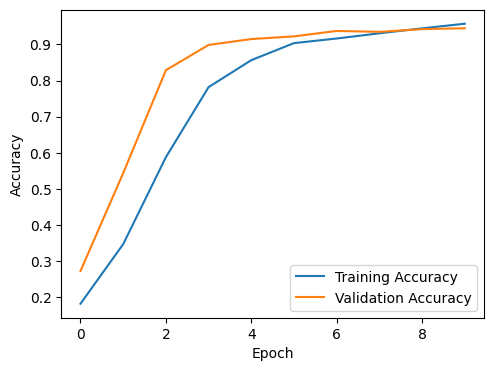

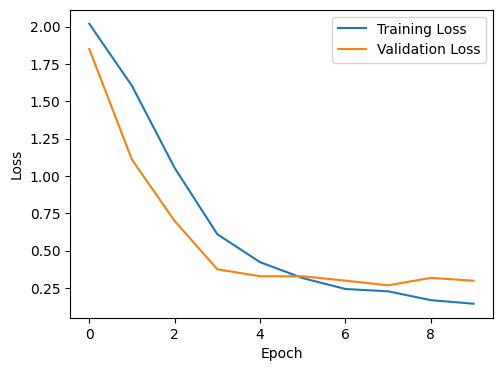

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
